In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Activation functions and their derivatives
def tanh(x):
    return np.tanh(x)

def tanh_Der(x):
    return 1 - tanh(x)**2

def sigmoid(x):
    ans = 1/(1 + np.exp(-x))
    return ans

def sigmoid_Der(x):
    ans = sigmoid(x) * (1 - sigmoid(x))
    return ans

def noAct(x):
    return x

def noAct_Der(x):
    return 1

def reLu(x):
    x = np.maximum(x, 0)
    return x

def reLu_Der(x):
    return (x > 0).astype(x.dtype)

def leakyreLu(x):
    return np.maximum(0.01 * x, x)

def leakyreLu_Der(x, alpha = 0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

In [19]:
#actFunc = 0 ==> No Activation Function (Linear)
#actFunc = 1 ==> tanh
#actFunc = 2 ==> sigmoid
#actFunc = 3 ==> ReLu
#actFunc = 4 ==> Leaky ReLu

class Layer:
    
    def __init__(self, nNodes, actFunc, prevLayerNodes):
        self.nodes = nNodes #number of nodes
        self.actFunction = actFunc #activation function identity
        self.activations = [noAct, tanh, sigmoid, reLu, leakyreLu] #list of activation functions
        self.activationDerivatives = [noAct_Der, tanh_Der, sigmoid_Der, reLu_Der, leakyreLu_Der] #list of activation function derivatives
        self.bias = 2 * np.random.random(nNodes) -1 #random bias
        self.weights = 2 * np.random.random([nNodes, prevLayerNodes]) - 1 #random weights
        self.error = None #will calculate during training
        self.delta = None #will calculate during training
        self.adjust = None #will calculate during training
        
    def activate(self, x):
        return self.activations[self.actFunction](x)
    
    def activationDer(self,x):
        return self.activationDerivatives[self.actFunction](x)
    
    def calculate(self, inputValues):
        #calculates output
        self.z = np.dot(inputValues, self.weights.T) + self.bias
        self.A = self.activate(self.z)
        self.dz = self.activationDer(self.z)
        return self.A

In [4]:
class Network:
    
    def __init__(self, nLayers, nodeCount, activations, outputAct, inputNodeCount, outputNodeCount):
        self.layers = nLayers #number of layers
        self.output = None
        
        self.layerList = [] #list of layers
        inputLayer = Layer(nodeCount[0], activations[0], inputNodeCount) #creating first hidden layer
        self.layerList.append(inputLayer)
        
        for i in range(1, nLayers):
            #creating layers in between first hidden layer and output layer
            currLayer = Layer(nodeCount[i], activations[i], nodeCount[i-1])
            self.layerList.append(currLayer)
        
        outputLayer = Layer(outputNodeCount, outputAct, nodeCount[nLayers - 1]) #creating output layer
        self.layerList.append(outputLayer)
        
    def calculateOutput(self, inputValues):
        for layer in self.layerList:
            self.output = layer.calculate(inputValues)
            inputValues = self.output
        return self.output
        
    def trainNetwork(self, inputValues, actualOutput, rate, max_iter, tol):
        
        for i in range(0, max_iter):
            currOut = self.calculateOutput(inputValues)
            
            error = currOut - actualOutput
            
            meanError = error**2
            meanError = np.mean(meanError)
            
            if(meanError < tol): break
            
            #adjusts output layer weights and bias
            currLayerIndex = len(self.layerList) - 1
            currLayer = self.layerList[currLayerIndex]
            prevLayer = self.layerList[currLayerIndex - 1]
            currLayer.error = error
            currLayer.delta = error * currLayer.dz
            currLayer.adjust = np.dot(prevLayer.A.T, currLayer.delta).T
            currLayer.weights -= rate * currLayer.adjust
            currLayer.bias -= rate * np.sum(currLayer.delta, axis = 0)
            currLayerIndex -= 1
            
            #adjusts intermediate hidden layers weights and bias
            while(currLayerIndex > 0):
                currLayer = self.layerList[currLayerIndex]
                nextLayer = self.layerList[currLayerIndex + 1]
                prevLayer = self.layerList[currLayerIndex - 1]
                currLayer.error = np.dot(nextLayer.delta, nextLayer.weights)
                currLayer.delta = currLayer.error * currLayer.dz
                currLayer.adjust = np.dot(prevLayer.A.T, currLayer.delta).T
                currLayer.weights -= rate * currLayer.adjust
                currLayer.bias -= rate * np.sum(currLayer.delta, axis = 0)
                currLayerIndex -= 1
            
            #adjusts first hidden layer weights and bias
            currLayer = self.layerList[currLayerIndex]
            nextLayer = self.layerList[currLayerIndex + 1]
            currLayer.error = np.dot(nextLayer.delta, nextLayer.weights)
            currLayer.delta = currLayer.error * currLayer.dz
            currLayer.adjust = np.dot(inputValues.T, currLayer.delta).T
            currLayer.weights -= rate * currLayer.adjust
            currLayer.bias -= rate * np.sum(currLayer.delta, axis = 0)
            
        return

In [21]:
#generating data
k = 11 #stiffness
m = 94 #mass
omega = (k/m)**0.5 
e = 0.1 #error
A = 10 #amplitude
phi = 5 #initial phase
n = 60 #number of data points

#generating data for n values of x 
x_meas = np.linspace(0, 2*np.pi/omega,num = n)
y_meas = np.zeros(len(x_meas))
y_actual = np.zeros(len(x_meas))

i = 0
for x in x_meas:
    y_actual[i] = A * np.cos(omega*x + phi)
    error = np.random.uniform(-1,1) * e * y_actual[i]
    y_meas[i] = y_actual[i] + error
    i += 1

In [ ]:
#modifying data a bit so that we can feed it to our network
inputValues = np.array(x_meas, ndmin = 2).T
y_actual = np.array(y_actual, ndmin = 2).T
yNorm = np.linalg.norm(y_actual)
outputValues = (y_actual/yNorm)

y_meas = np.array(y_meas, ndmin = 2)
y_meas = y_meas/np.linalg.norm(y_meas)

In [23]:
#creating neural network
nodeCount = [3,5,6]
activations = [1,1,1]
outputActivation = 1
inputNodeCount = 1
outputNodeCount = 1
nn = Network(3, nodeCount, activations, outputActivation, inputNodeCount, outputNodeCount)


In [ ]:
#training the network
max_iter = 200000
rate = 0.001
tol = 0.00001

nn.trainNetwork(inputValues, outputValues, rate, max_iter, tol)

networkOutput = nn.calculateOutput(inputValues)
actualOutput = networkOutput * yNorm

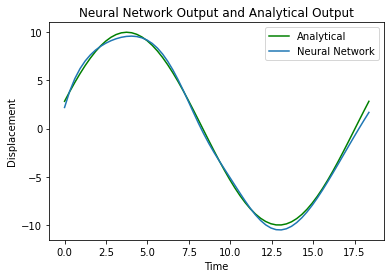

In [18]:
#plotting
plt.plot(x_meas,y_actual, 'g',markersize = 1, label = 'Analytical')
plt.plot(x_meas, actualOutput, label = 'Neural Network')
plt.title('Neural Network Output and Analytical Output')
plt.ylabel('Displacement')
plt.xlabel('Time')
plt.legend()
plt.show()